# Compare sorters with some dataset generated with MEArec

Alessio Paolo Buccino author of [MEArec](https://github.com/alejoe91/MEArec) have generated some dataset

Here a comparison on the file **recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13_31.h5**


In [1]:
import spiketoolkit as st
import spikeextractors as se

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import time

%matplotlib notebook

## Step 1 : open the dataset

The file have been downloaded in the current directory.

Note: this file have a 3D geometry for teh probe. Many sorters work only with 2D.
So here we remove the first dimenssion of "location" in the recording.


In [2]:
mearec_filename = 'recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13_31.h5'
rec0  = se.MEArecRecordingExtractor(mearec_filename)
gt_sorting0 = se.MEArecSortingExtractor(mearec_filename)

# patch to force geometry to be 2D
for chan in rec0.get_channel_ids():
    loc = rec0.get_channel_property(chan, 'location')
    rec0.set_channel_property(chan, 'location', loc[1:])

## Step 2 : run all sorter

This run all sorter on all recording and store the results in a working folder.

In [3]:
# this cell is really verbose due to some sorter so switch off output console
recording_dict = {'rec0' : rec0}
# sorter_list = ['tridesclous',]
sorter_list = ['tridesclous', 'herdingspikes', 'spykingcircus']
# sorter_list = ['tridesclous', 'herdingspikes','klusta', 'mountainsort4', 'spykingcircus']
# 'kilosort', 'kilosort2', 'ironclust' are not tested because I don't have matlab

working_folder = './working_folder'

In [ ]:
t0 = time.perf_counter()
st.sorters.run_sorters(sorter_list, recording_dict, working_folder, engine=None)
t1 = time.perf_counter()
print('total run time', t1-t0)

## Step3 : collect Datatframe of comparison

This collect all results for all **(rec_name, sorter_name)** pair and apply the SortingComparison class for each.

This also concatenate performances in several dataframes.

In [4]:
ground_truths = {'rec0': gt_sorting0}

comparisons, dataframes = st.comparison.gather_sorting_comparison(working_folder, ground_truths,use_multi_index=True)

/home/samuel/.virtualenvs/py36/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/samuel/Documents/projet/spikeinterface/spiketoolkit/spiketoolkit/comparison/comparisontools.py:348: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  FP = sum([len(np.where('FP' == labels_st2[u2])[0]) for u2 in unit2_ids])


## Step 4 : display tables

**dataframes** is a dict that contain several results formated in dataframes:
  * run_times : time for computing each one
  * perf_pooled_with_sum: performance with method **pooled_with_sum**
  * perf_pooled_with_average: performance with method **pooled_with_average**
  * nb_units_above_threshold: count how many units detect with a treshold on a perf columns.

In [5]:
dataframes['run_times']

run_time
rec_name sorter_name               
rec0     tridesclous     198.192449
         herdingspikes    11.666788
         spykingcircus  1850.040399

In [6]:
dataframes['perf_pooled_with_sum']

tp_rate  fn_rate   cl_rate fp_rate_st1 fp_rate_st2  \
rec_name sorter_name                                                         
rec0     tridesclous    68.7081  30.6597  0.632209     17.9094     20.5504   
         herdingspikes   46.407  51.8508   1.74219     6.96878      12.847   
         spykingcircus  38.2076  60.8754  0.916944     40.3842     51.2871   

                       accuracy sensitivity precision miss_rate  \
rec_name sorter_name                                              
rec0     tridesclous    58.5861     69.1452   79.3236   30.8548   
         herdingspikes   44.102     47.2299   86.9439   52.7701   
         spykingcircus  27.3954     38.5612   48.6153   61.4388   

                       false_discovery_rate  
rec_name sorter_name                         
rec0     tridesclous                20.6764  
         herdingspikes              13.0561  
         spykingcircus              51.3847

In [7]:
dataframes['perf_pooled_with_average']

tp_rate  fn_rate  cl_rate fp_rate_st1 fp_rate_st2  \
rec_name sorter_name                                                        
rec0     tridesclous    58.7316  40.7849  58.7316     10.1833     11.2962   
         herdingspikes  46.8357  51.5285  46.8357     2.00167     4.72088   
         spykingcircus   37.361  61.8285   37.361     1.98548      4.3272   

                       accuracy sensitivity precision miss_rate  \
rec_name sorter_name                                              
rec0     tridesclous    52.3918     59.2016   88.5424   40.7984   
         herdingspikes  47.8243      48.285   95.2346    51.715   
         spykingcircus  37.6752     37.8056    95.599   62.1944   

                       false_discovery_rate  
rec_name sorter_name                         
rec0     tridesclous                11.4576  
         herdingspikes              4.76543  
         spykingcircus              4.40096

In [8]:
dataframes['nb_units_above_threshold']

nb_above(with_tp_rate)  nb_above(with_accuracy)  \
rec_name sorter_name                                                      
rec0     tridesclous                        28                       17   
         herdingspikes                      16                       17   
         spykingcircus                       4                        5   

                        nb_above(with_sensitivity)  
rec_name sorter_name                                
rec0     tridesclous                            29  
         herdingspikes                          20  
         spykingcircus                           6

## Step 5: inspect result by spiketrain

For finer exploration, we can also compute for all **(rec_name, sorter_name)** pair the performance with method=**by_spiketrain**.

This give a give result for each units of the ground truth.

In [8]:
for (rec_name, sorter_name), comp in comparisons.items():
    print(rec_name, sorter_name)
    perf = comp.get_performance(method='by_spiketrain')
    display(perf)

rec0 herdingspikes


,tp_rate,fn_rate,cl_rate,fp_rate_st1,fp_rate_st2,accuracy,sensitivity,precision,miss_rate,false_discovery_rate
0,0,100,0,0,NaN,0,0,NaN,100,NaN
1,95.8869,0.514139,95.8869,1.02828,1.02828,98.4169,99.4667,98.939,0.533333,1.06101
2,0,100,0,0,NaN,0,0,NaN,100,NaN
3,97.2973,1.08108,97.2973,1.08108,1.07527,97.8261,98.9011,98.9011,1.0989,1.0989
4,100,0,100,0,0,100,100,100,0,0
5,89.3162,6.41026,89.3162,1.7094,1.86047,91.6667,93.3036,98.1221,6.69643,1.87793
6,99.6241,0,99.6241,0,0,100,100,100,0,0
7,96.0784,1.30719,96.0784,1.96078,1.94805,96.7105,98.6577,98,1.34228,2
8,93.6667,1,93.6667,0.333333,0.341297,98.5965,98.9437,99.6454,1.05634,0.35461
9,0,100,0,0,NaN,0,0,NaN,100,NaN


rec0 spykingcircus


,tp_rate,fn_rate,cl_rate,fp_rate_st1,fp_rate_st2,accuracy,sensitivity,precision,miss_rate,false_discovery_rate
0,0,100,0,0,NaN,0,0,NaN,100,NaN
1,0,100,0,0,NaN,0,0,NaN,100,NaN
2,60.4878,36.3415,60.4878,0,0,62.4685,62.4685,100,37.5315,0
3,51.8919,44.3243,51.8919,0,0,53.9326,53.9326,100,46.0674,0
4,99.569,0.431034,99.569,0,0,99.569,99.569,100,0.431034,0
5,63.6752,33.3333,63.6752,0,0,65.6388,65.6388,100,34.3612,0
6,0,100,0,0,NaN,0,0,NaN,100,NaN
7,64.3791,33.9869,64.3791,0,0,65.4485,65.4485,100,34.5515,0
8,80.3333,19,80.3333,0.333333,0.413223,80.602,80.8725,99.5868,19.1275,0.413223
9,0,100,0,0,NaN,0,0,NaN,100,NaN


rec0 tridesclous


,tp_rate,fn_rate,cl_rate,fp_rate_st1,fp_rate_st2,accuracy,sensitivity,precision,miss_rate,false_discovery_rate
0,0,100,0,0,NaN,0,0,NaN,100,NaN
1,96.144,0.514139,96.144,0,0,99.4681,99.4681,100,0.531915,0
2,100,0,100,0.487805,0.485437,99.5146,100,99.5146,0,0.485437
3,98.9189,1.08108,98.9189,0,0,98.9189,98.9189,100,1.08108,0
4,99.569,0.431034,99.569,0,0,99.569,99.569,100,0.431034,0
5,0,100,0,0,NaN,0,0,NaN,100,NaN
6,99.2481,0.75188,99.2481,0,0,99.2481,99.2481,100,0.75188,0
7,99.0196,0.326797,99.0196,0,0,99.6711,99.6711,100,0.328947,0
8,97,0,97,73,42.6901,57.0588,100,57.0588,0,42.9412
9,0,100,0,0,NaN,0,0,NaN,100,NaN


## Step 6 : easy plot with seaborn

With the seaborn package, it is very easy to summary with plot dataframes.

Here some basic example for performances and run times.

### Run times

Text(0.5,1,'Run times (s)')

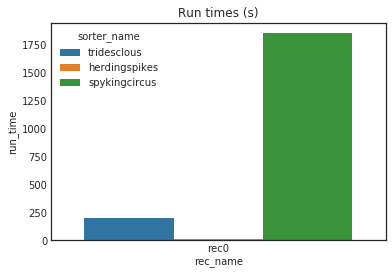

In [17]:
run_times = dataframes['run_times'].reset_index()
fig, ax = plt.subplots()
sn.barplot(data=run_times, x='rec_name', y='run_time', hue='sorter_name', ax=ax)
ax.set_title('Run times (s)')

### True positive rate

(0, 100)

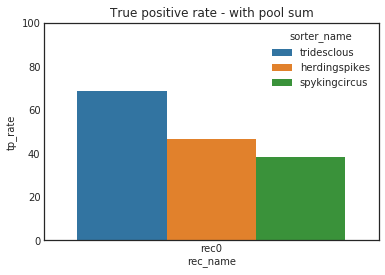

In [21]:
perfs = dataframes['perf_pooled_with_sum'].reset_index()
fig, ax = plt.subplots()
sn.barplot(data=perfs, x='rec_name', y='tp_rate', hue='sorter_name', ax=ax)
ax.set_title('True positive rate - with pool sum')
ax.set_ylim(0, 100)

(0, 100)

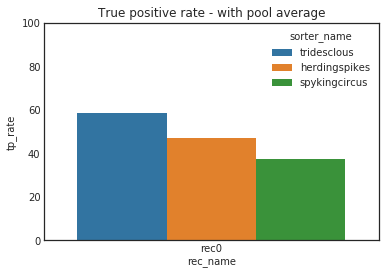

In [22]:
perfs = dataframes['perf_pooled_with_average'].reset_index()
fig, ax = plt.subplots()
sn.barplot(data=perfs, x='rec_name', y='tp_rate', hue='sorter_name', ax=ax)
ax.set_title('True positive rate - with pool average')
ax.set_ylim(0, 100)

### Accuracy

(0, 100)

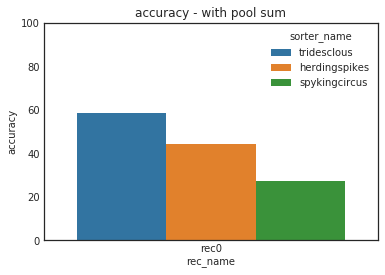

In [23]:
perfs = dataframes['perf_pooled_with_sum'].reset_index()
fig, ax = plt.subplots()
ax = sn.barplot(data=perfs, x='rec_name', y='accuracy', hue='sorter_name', ax=ax)
ax.set_title('accuracy - with pool sum')
ax.set_ylim(0, 100)

### How many units detected above threshold

The max is 50 cells.

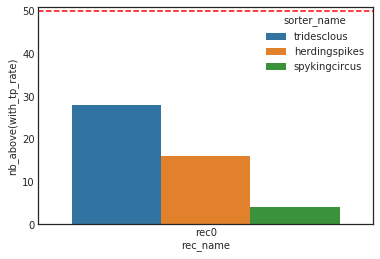

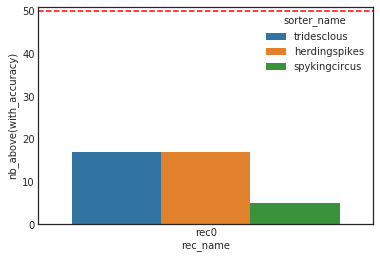

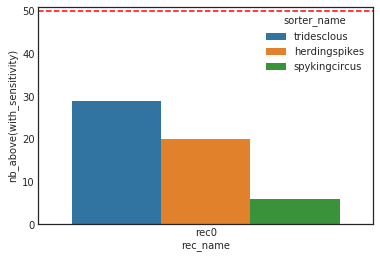

In [12]:
perfs = dataframes['nb_units_above_threshold'].reset_index()

for col in ['nb_above(with_tp_rate)', 'nb_above(with_accuracy)', 'nb_above(with_sensitivity)']:
    fig, ax = plt.subplots()
    ax = sn.barplot(data=perfs, x='rec_name', y=col, hue='sorter_name', ax=ax)
    ax.set_ylim(0, 51)
    ax.axhline(50, ls='--', color='red')